In [1]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History
from keras.losses import *
from keras import backend as K
import os, time
from matplotlib import pyplot as plt
from model_utilities import DistortImages, VisualizeImage, VisualizeImageWithPrediction

C:\Users\Razer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define our Attention Model Here

Here, We will first define the attention block, then we will use it in a keras model

In [40]:
def AttentionBlock(x, shortcut, num_filters):
    '''
    function that defines the attention gated block for our U-Net Model

    Arguments:
        x {tensor} -- Input from previous decoding upscale layer
        shortcut {tensor} -- Corresponding input from the same level encoder layer
        num_filters {int} -- total filters used for that layer in decoder

    Returns:
        {tensor} -- the output of the attention gate to be concatenated with that layer in decoder
    '''
    g1 = Conv2D(num_filters, kernel_size = 1, kernel_initializer = "he_normal")(shortcut)
    g1 = BatchNormalization()(g1)
    x1 = Conv2D(num_filters, kernel_size = 1, kernel_initializer = "he_normal")(x)
    x1 = BatchNormalization()(x1)
    
    g1_x1 = Add()([g1, x1])
    psi = Activation("elu")(g1_x1)
    psi = Conv2D(1, kernel_size = 1)(psi)
    psi = BatchNormalization()(psi)
    psi = Activation("sigmoid")(psi)
    x = Multiply()([x, psi])
    return x

In [3]:
def UNet(shape, reuse = False, n_out = 1, pretrained_weights = None):
    
    nnx = int(shape[1])
    nny = int(shape[2])
    nnz = int(shape[3])
    print(" * Input: size of image: %d %d %d" % (nnx, nny, nnz))
    with tf.variable_scope("u_net", reuse = reuse):
        
        # Encoder
        inputs = Input((nnx, nny, nnz))
        
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
        pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
        pool2 = MaxPool2D(pool_size = (2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
        pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
        conv4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
        
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
        conv5 = Dropout(0.5)(conv5)
        
        # Decoder ;_;
        up6 = Conv2D(512, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv5))
        merge6 = concatenate([conv4, up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge6)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)
        
        up7 = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3, up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge7)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)
        
        up8 = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2, up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge8)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)
        
        up9 = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1, up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge9)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        conv10 = Conv2D(n_out, 1, activation = "sigmoid", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        model = Model(inputs = inputs, outputs = conv10)
        if pretrained_weights:
            model.load(pretrained_weights)
        
        return model

In [41]:
def UNetWithAttention(shape, reuse = False, n_out = 1, pretrained_weights = None):
    
    nnx = int(shape[1])
    nny = int(shape[2])
    nnz = int(shape[3])
    print(" * Input: size of image: %d %d %d" % (nnx, nny, nnz))
    with tf.variable_scope("u_net", reuse = reuse):
        
        # Encoder
        inputs = Input((nnx, nny, nnz))
        
        conv1 = Conv2D(64, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(inputs)
        conv1 = Conv2D(64, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv1)
        pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(pool1)
        conv2 = Conv2D(128, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv2)
        pool2 = MaxPool2D(pool_size = (2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(pool2)
        conv3 = Conv2D(256, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv3)
        pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(pool3)
        conv4 = Conv2D(512, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv4)
        conv4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
        
        conv5 = Conv2D(1024, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(pool4)
        conv5 = Conv2D(1024, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv5)
        conv5 = Dropout(0.5)(conv5)
        
        # Decoder ;_;
        up6 = Conv2D(512, 2, activation = "elu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv5))
        atn6 = AttentionBlock(x = up6, shortcut = conv4, num_filters = 512)
        merge6 = concatenate([atn6, up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(merge6)
        conv6 = Conv2D(512, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv6)
        
        up7 = Conv2D(256, 2, activation = "elu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv6))
        atn7 = AttentionBlock(x = up7, shortcut = conv3, num_filters = 256)
        merge7 = concatenate([atn7, up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(merge7)
        conv7 = Conv2D(256, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv7)
        
        up8 = Conv2D(128, 2, activation = "elu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv7))
        atn8 = AttentionBlock(x = up8, shortcut = conv2, num_filters = 128)
        merge8 = concatenate([atn8, up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(merge8)
        conv8 = Conv2D(128, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv8)
        
        up9 = Conv2D(64, 2, activation = "elu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv8))
        atn9 = AttentionBlock(x = up9, shortcut = conv1, num_filters = 64)
        merge9 = concatenate([atn9, up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(merge9)
        conv9 = Conv2D(64, 3, activation = "elu", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        conv10 = Conv2D(n_out, 1, activation = "sigmoid", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        model = Model(inputs = inputs, outputs = conv10)
        if pretrained_weights:
            model.load(pretrained_weights)
        
        return model

# Setting up folders for checkpoints and testing

In [42]:
import os
save_dir = "./checkpoint"
task = "all"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists("./sample/{}".format(task)):
    os.mkdir("./sample")
    os.mkdir("./sample/{}".format(task))

In [43]:
if not os.path.exists("./test/{}".format(task)):
    os.mkdir("./test")
    os.mkdir("./test/{}".format(task))

## Prepare and load data
Here, we will load the entire data and preprocess it as and when necessary.

In [44]:
import prepare_data_with_valid4 as dataset

In [45]:
XTrain = dataset.X_train_input
yTrain = dataset.X_train_target[:, :, :, np.newaxis]
XTest = dataset.X_dev_input
yTest = dataset.X_dev_target[:, :, :, np.newaxis]

yTrain = (yTrain > 0).astype(int)
yTest = (yTest > 0).astype(int)

# Visualize a slice
X = np.asarray(XTrain[80])
y = np.asarray(yTrain[80])
nw, nh, nz = X.shape
VisualizeImage(X, y, 'sample/{}/_train_im.png'.format(task))

In [46]:
yTest_ar = np.asarray(yTest)
yTest_ar = np.squeeze(yTest)
yTest_ar.shape
y_sq = np.squeeze(y)

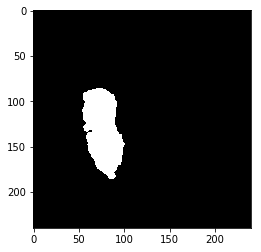

In [47]:
plt.imshow(y_sq, cmap = "gray")

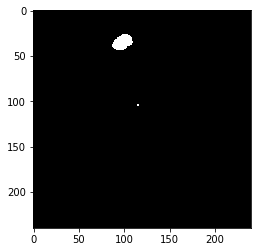

In [48]:
plt.imshow(yTest_ar[48, :, :], cmap = "gray")

# Data Augmentation Testing

Here, we will check the preprocessing functions and make sure that they work properly

In [49]:
# Show the data augmentation
for i in range(10):
    x_flair, x_t1, x_t1ce, x_t2, label = DistortImages([X[:, :, 0, np.newaxis], 
                                                   X[:, :, 1, np.newaxis], 
                                                   X[:, :, 2, np.newaxis], 
                                                   X[:, :, 3, np.newaxis], y])
    X_dis = np.concatenate((x_flair, x_t1, x_t1ce, x_t2), axis = 2)
    X_d = np.concatenate((X[:, :, 0, np.newaxis], X[:, :, 1, np.newaxis], X[:, :, 2, np.newaxis], X[:, :, 3, np.newaxis]), axis = 2)
    VisualizeImage(X_dis, label, 'sample/{}/_train_im_aug{}.png'.format(task, i))
    VisualizeImage(X_d, label, 'sample/{}/_sample_im_aug{}.png'.format(task, i))
    if i == 0:
        print(x_flair.shape, x_t1.shape, x_t1ce.shape, x_t2.shape, label.shape, sep="\n")
        print(X_dis.shape, X_dis.min(), X_dis.max(), sep="\n")

(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 4)
-0.4942935705184939
28.707836530318723


## HyperParameter Setting
Here we will set the hyperparams necessary to jolt our model for training

In [55]:
batch_size = 5
lr = 0.0001
beta1 = 0.9
n_epoch = 5
printFreq = 10

## Define our Loss Functions here

In [51]:
def dice_coef(y_true, y_pred, smooth = 1):
    '''
    Function that defines the dice_coef
    Dice = (2*|X & Y|)/ (|X|+ |Y|) = 2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    '''
    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    return (2. * intersection + smooth)/(K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## Train our model

In [52]:
model = UNetWithAttention(shape = (batch_size, nw, nh, nz))
model.compile(optimizer = Adam(lr=lr, beta_1=beta1), loss = "binary_crossentropy", metrics = ["accuracy"])

 * Input: size of image: 240 240 4


In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

add_2 (Add)                     (None, 60, 60, 256)  0           batch_normalization_4[0][0]      
                                                                 batch_normalization_5[0][0]      
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 60, 60, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 60, 60, 1)    257         activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 60, 60, 1)    4           conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 60, 60, 1)    0           batch_normalization_6[0][0]      
__________

__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 240, 240, 64) 73792       concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 240, 240, 64) 36928       conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 240, 240, 1)  65          conv2d_34[0][0]                  
Total params: 31,739,221
Trainable params: 31,735,373
Non-trainable params: 3,848
__________________________________________________________________________________________________


In [56]:
train_history = History()
for epoch in range(0, n_epoch):
    epoch_time = time.time()
    n_batch = 0
    print("[+] Epoch ==> ",epoch + 1)
    for batch in tl.iterate.minibatches(inputs = XTrain, targets = yTrain, batch_size = batch_size, shuffle = True):
        images, labels = batch

        data = tl.prepro.threading_data([_ for _ in zip(images[:,:,:,0, np.newaxis],
                        images[:,:,:,1, np.newaxis], images[:,:,:,2, np.newaxis],
                        images[:,:,:,3, np.newaxis], labels)], fn = DistortImages)
        bImages = data[:, 0:4, :, :, :]
        bLabels = data[:, 4, :, :, :]
        bImages = bImages.transpose((0, 2, 3, 1, 4))
        bImages.shape = (batch_size, nw, nh, nz)

        model.fit(x = bImages, y = labels, batch_size = batch_size, verbose = 0, shuffle = False, callbacks=[train_history])
        n_batch += 1
        
        if n_batch % printFreq == 0:
            print("batch ==> ", n_batch, ", images parsed ==> ", batch_size * n_batch)
            print(train_history.history)
    
    print("[+] Epoch over ==> ", epoch + 1, " out of ", n_epoch)
    print(train_history.history)

[+] Epoch ==>  1
batch ==>  10 , images parsed ==>  50
{'loss': [0.05733061581850052], 'acc': [0.9929166436195374]}
batch ==>  20 , images parsed ==>  100
{'loss': [0.01574086770415306], 'acc': [0.9973750114440918]}
batch ==>  30 , images parsed ==>  150
{'loss': [0.016511332243680954], 'acc': [0.9990312457084656]}
batch ==>  40 , images parsed ==>  200
{'loss': [0.07624413073062897], 'acc': [0.9747465252876282]}
batch ==>  50 , images parsed ==>  250
{'loss': [0.017089031636714935], 'acc': [0.9972291588783264]}
batch ==>  60 , images parsed ==>  300
{'loss': [0.026660338044166565], 'acc': [0.9961458444595337]}
batch ==>  70 , images parsed ==>  350
{'loss': [0.07177143543958664], 'acc': [0.9779375195503235]}
batch ==>  80 , images parsed ==>  400
{'loss': [0.0008106821333058178], 'acc': [1.0]}
batch ==>  90 , images parsed ==>  450
{'loss': [0.01021633855998516], 'acc': [1.0]}
batch ==>  100 , images parsed ==>  500
{'loss': [0.06412281095981598], 'acc': [0.9897013902664185]}
batch ==

{'loss': [0.024346698075532913], 'acc': [0.9940798878669739]}
batch ==>  210 , images parsed ==>  1050
{'loss': [0.06805909425020218], 'acc': [0.9783090353012085]}
batch ==>  220 , images parsed ==>  1100
{'loss': [0.014393003657460213], 'acc': [0.996874988079071]}
batch ==>  230 , images parsed ==>  1150
{'loss': [0.06367620080709457], 'acc': [0.9773125052452087]}
batch ==>  240 , images parsed ==>  1200
{'loss': [0.009707652032375336], 'acc': [0.9977569580078125]}
batch ==>  250 , images parsed ==>  1250
{'loss': [0.016847463324666023], 'acc': [0.9954305291175842]}
batch ==>  260 , images parsed ==>  1300
{'loss': [0.025586863979697227], 'acc': [0.9937951564788818]}
batch ==>  270 , images parsed ==>  1350
{'loss': [0.004350210539996624], 'acc': [1.0]}
batch ==>  280 , images parsed ==>  1400
{'loss': [0.021736662834882736], 'acc': [0.9945243000984192]}
batch ==>  290 , images parsed ==>  1450
{'loss': [0.03106342814862728], 'acc': [0.9868437647819519]}
batch ==>  300 , images parsed

{'loss': [0.033675242215394974], 'acc': [0.9862222075462341]}
batch ==>  400 , images parsed ==>  2000
{'loss': [0.00672328332439065], 'acc': [0.9990485906600952]}
batch ==>  410 , images parsed ==>  2050
{'loss': [0.03127339482307434], 'acc': [0.9861562252044678]}
batch ==>  420 , images parsed ==>  2100
{'loss': [0.03221637010574341], 'acc': [0.9877569675445557]}
batch ==>  430 , images parsed ==>  2150
{'loss': [0.01427844725549221], 'acc': [0.9966388940811157]}
batch ==>  440 , images parsed ==>  2200
{'loss': [0.04509435221552849], 'acc': [0.9861770868301392]}
batch ==>  450 , images parsed ==>  2250
{'loss': [0.03252517431974411], 'acc': [0.9897639155387878]}
batch ==>  460 , images parsed ==>  2300
{'loss': [0.020668137818574905], 'acc': [0.9933993220329285]}
batch ==>  470 , images parsed ==>  2350
{'loss': [0.006150454748421907], 'acc': [0.9989756941795349]}
batch ==>  480 , images parsed ==>  2400
{'loss': [0.009066173806786537], 'acc': [0.9989235997200012]}
batch ==>  490 , 

{'loss': [0.046430785208940506], 'acc': [0.9860937595367432]}
batch ==>  580 , images parsed ==>  2900
{'loss': [0.03962920233607292], 'acc': [0.9889097213745117]}
batch ==>  590 , images parsed ==>  2950
{'loss': [0.031035328283905983], 'acc': [0.9928749799728394]}
batch ==>  600 , images parsed ==>  3000
{'loss': [0.011213326826691628], 'acc': [0.9975937604904175]}
batch ==>  610 , images parsed ==>  3050
{'loss': [0.02373925782740116], 'acc': [0.9907916784286499]}
[+] Epoch over ==>  4  out of  5
{'loss': [0.05075880140066147], 'acc': [0.9835346937179565]}
[+] Epoch ==>  5
batch ==>  10 , images parsed ==>  50
{'loss': [0.0034683458507061005], 'acc': [0.999836802482605]}
batch ==>  20 , images parsed ==>  100
{'loss': [0.0002773186715785414], 'acc': [1.0]}
batch ==>  30 , images parsed ==>  150
{'loss': [0.00011084412835771218], 'acc': [1.0]}
batch ==>  40 , images parsed ==>  200
{'loss': [0.01677796244621277], 'acc': [0.9956701397895813]}
batch ==>  50 , images parsed ==>  250
{'l

In [57]:
net_json = model.to_json()
with open("unet.json", "w") as json_file:
    json_file.write(net_json)
model.save_weights("unet.h5")
print("[+] Model Saved in disk")

[+] Model Saved in disk


## Test saved model
### 1. Load the model

In [58]:
jsonFile = open('unet.json', "r")
loadedModelJson = jsonFile.read()
jsonFile.close()

model = model_from_json(loadedModelJson)
model.load_weights("unet.h5")
print("[+] Model loaded")
model.compile(optimizer = Adam(lr=lr, beta_1=beta1), loss = 'binary_crossentropy', metrics = ["accuracy"])

[+] Model loaded


### 2. Test predictions

In [59]:
model.evaluate(x = XTest, y = yTest, batch_size = batch_size, verbose = 1)

1071/1071 [==============================] - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA:

[0.012250377741494142, 0.9995959932062807]

In [60]:
outPred = model.predict(XTest, batch_size = batch_size, verbose=1)

1071/1071 [==============================] - ETA: 7: - ETA: 4: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA:

In [61]:
for i in range(outPred.shape[0]):
    VisualizeImageWithPrediction(XTest[i], yTest[i], outPred[i], "./test/{}/test_{}.png".format(task, i))

In [62]:
outPredTrain = model.predict(XTrain, batch_size = batch_size, verbose=1)

3060/3060 [==============================] - ETA: 13:3 - ETA: 7:5 - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ET

In [63]:
for i in range(outPred.shape[0]):
    VisualizeImageWithPrediction(XTrain[i], yTrain[i], outPred[i], "./train/{}/train_{}.png".format(task, i))